<a href="https://colab.research.google.com/github/dhruvaditya/YOLO_v8/blob/main/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by: Aditya Raj

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')



In [ ]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 107MB/s]


In [ ]:
result = model.predict('/content/Screenshot (173).png') # Add the relative path to the image


image 1/1 /content/Screenshot (173).png: 384x640 1 person, 419.6ms
Speed: 22.0ms preprocess, 419.6ms inference, 32.1ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
res = result[0]
print (len (res.boxes))

1


In [ ]:
for box in res.boxes:
  label = res.names[box.cls[0].item()]
  cords = [round(x) for x in box.xyxy[0].tolist()]
  prob = box.conf[0].item()
  print (label, cords)
  print ("probabilty" , prob)

person [756, 139, 1620, 1071]
probabilty 0.950785756111145


Fine-tuning YOLOv8 with Custom Dataset Generated by Open-world Object Detector

In [ ]:
import os
from groundingdino.util.inference import load_model, load_image, predict, annotate

def run_dino(dino, image, text_prompt='food', box_threshold=0.4, text_threshold=0.1):
    boxes, logits, phrases = predict(
        model = dino,
        image = image,
        caption = text_prompt,
        box_threshold = box_threshold,
        text_threshold = text_threshold
    )
    return boxes, logits, phrases

model = load_model('GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py', 'groundingdino_swint_ogc.pth')

os.system('wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg')
image_source, image = load_image('dog.jpeg')
boxes, logits, phrases = run_dino(dino, image, text_prompt='dog')

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

ModuleNotFoundError: No module named 'groundingdino'

I annotated the Food-101 dataset using Grounding DINO following the directory format for fine-tuning YOLO.

In [ ]:
from datasets import load_dataset

def annotate(dino, data, data_size, data_dir):
    data = data.train_test_split(train_size=min(len(data), data_size))['train']

    image_dir = f'{data_dir}/images'
    label_dir = f'{data_dir}/labels'
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i, d in enumerate(tqdm(data)):
        image_path = f'{image_dir}/{i:06d}.png'
        label_path = f'{label_dir}/{i:06d}.txt'
        image = d['image'].resize((640, 640))
        image.save(image_path)

        image_source, image = load_image(image_path)
        boxes, logits, phrases = run_dino(dino, image)

        label = ['0 ' + ' '.join(list(map(str, b))) for b in boxes.tolist()]
        label = '\n'.join(label)
        with open(label_path, 'w') as f:
            f.write(label)


data = load_dataset('food101')
annotate(dino, data['train'], 3000, 'data/train')
annotate(dino, data['validation'], 1000, 'data/valid')

config = {
    'names': ['food'],
    'nc': 1,
    'train': 'train/images',
    'val': 'valid/images'
}

with open('data/data.yaml', 'w') as f:
    yaml.dump(config, f)

Fine-tuning YOLOv8 using Generated Dataset

In [ ]:
from ultralytics import YOLO

yolo = YOLO('yolov8n.pt')
yolo.train(data='/content/data/data.yaml', epochs=5)
valid_results = yolo.val()
print(valid_results)

Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

RuntimeError: Dataset '/content/data/data.yaml' error ❌ '/content/data/data.yaml' does not exist

Code for running fine tuned YOLO

In [ ]:

def run_yolo(yolo, image_url, conf=0.25, iou=0.7):
    results = yolo(image_url, conf=conf, iou=iou)
    res = results[0].plot()[:, :, [2,1,0]]
    return Image.fromarray(res)

yolo = YOLO('runs/detect/train/weights/best.pt')

image_url = 'test-01.jpg'
predict(image_url)

I fine-tuned pre-trained YOLOv8 model to detect new classes. I can construct a custom object detection dataset without manual annotation by using open-world object detector, Grounding DINO.

In the future, I plan to increase the number of classses and test more challenging classes.

Here’s how to use the model for zero-shot object detection:

In [2]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model_id = "IDEA-Research/grounding-dino-tiny"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
# Check for cats and remote controls
text = "a cat. a remote control."

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

NameError: name 'device' is not defined

GroundingDINO  We'll use Grounding DINO to generate bounding boxes based on text prompts

In [3]:
!pip install --upgrade -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

In [5]:
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))

In [6]:
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

In [7]:
def random_named_css_colors(num_colors: int) -> List[str]:
    """
    Returns a list of randomly selected named CSS colors.

    Args:
    - num_colors (int): Number of random colors to generate.

    Returns:
    - list: List of randomly selected named CSS colors.
    """
    # List of named CSS colors
    named_css_colors = [
        'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond',
        'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
        'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey',
        'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
        'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
        'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite',
        'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory',
        'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow',
        'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray',
        'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine',
        'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise',
        'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive',
        'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
        'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown',
        'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey',
        'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white',
        'whitesmoke', 'yellow', 'yellowgreen'
    ]

    # Sample random named CSS colors
    return random.sample(named_css_colors, min(num_colors, len(named_css_colors)))

def plot_detections_plotly(
    image: np.ndarray,
    detections: List[DetectionResult],
    class_colors: Optional[Dict[str, str]] = None
) -> None:
    # If class_colors is not provided, generate random colors for each class
    if class_colors is None:
        num_detections = len(detections)
        colors = random_named_css_colors(num_detections)
        class_colors = {}
        for i in range(num_detections):
            class_colors[i] = colors[i]


    fig = px.imshow(image)

    # Add bounding boxes
    shapes = []
    annotations = []
    for idx, detection in enumerate(detections):
        label = detection.label
        box = detection.box
        score = detection.score
        mask = detection.mask

        polygon = mask_to_polygon(mask)

        fig.add_trace(go.Scatter(
            x=[point[0] for point in polygon] + [polygon[0][0]],
            y=[point[1] for point in polygon] + [polygon[0][1]],
            mode='lines',
            line=dict(color=class_colors[idx], width=2),
            fill='toself',
            name=f"{label}: {score:.2f}"
        ))

        xmin, ymin, xmax, ymax = box.xyxy
        shape = [
            dict(
                type="rect",
                xref="x", yref="y",
                x0=xmin, y0=ymin,
                x1=xmax, y1=ymax,
                line=dict(color=class_colors[idx])
            )
        ]
        annotation = [
            dict(
                x=(xmin+xmax) // 2, y=(ymin+ymax) // 2,
                xref="x", yref="y",
                text=f"{label}: {score:.2f}",
            )
        ]

        shapes.append(shape)
        annotations.append(annotation)

    # Update layout
    button_shapes = [dict(label="None",method="relayout",args=["shapes", []])]
    button_shapes = button_shapes + [
        dict(label=f"Detection {idx+1}",method="relayout",args=["shapes", shape]) for idx, shape in enumerate(shapes)
    ]
    button_shapes = button_shapes + [dict(label="All", method="relayout", args=["shapes", sum(shapes, [])])]

    fig.update_layout(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        # margin=dict(l=0, r=0, t=0, b=0),
        showlegend=True,
        updatemenus=[
            dict(
                type="buttons",
                direction="up",
                buttons=button_shapes
            )
        ],
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Show plot
    fig.show()

In [8]:
def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks

Grounded Segment Anything (SAM)
Now it's time to define the Grounded SAM approach!

The approach is very simple:

use Grounding DINO to detect a given set of texts in the image. The output is a set of bounding boxes.
prompt Segment Anything (SAM) with the bounding boxes, for which the model will output segmentation masks.

In [9]:
def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"

    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    masks = refine_masks(masks, polygon_refinement)

    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = mask

    return detection_results

def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, labels, threshold, detector_id)
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections

In [10]:
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
labels = ["a cat.", "a remote control."]
threshold = 0.3

detector_id = "IDEA-Research/grounding-dino-tiny"
segmenter_id = "facebook/sam-vit-base"

In [11]:
image_array, detections = grounded_segmentation(
    image=image_url,
    labels=labels,
    threshold=threshold,
    polygon_refinement=True,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Let's Visualize the result:

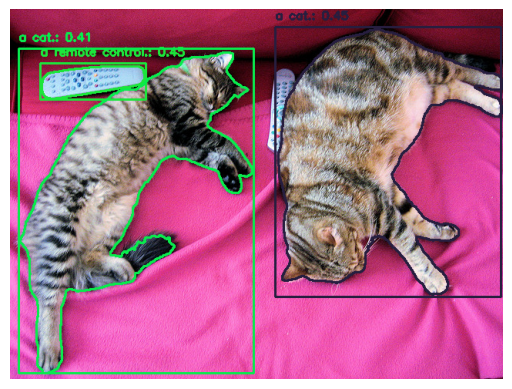

In [12]:
plot_detections(image_array, detections, "cute_cats.png")

In [13]:
plot_detections_plotly(image_array, detections)